In [297]:
#!pip install category_encoders
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.utils import resample
import statistics
import category_encoders as ce
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

In [298]:
def get_encoding(column):# helper method for getting one-hot encoding
    return dict(enumerate(column.unique()))
    

In [299]:
"""
def mapping(column,dic):
    encoder = ce.OrdinalEncoder(cols = column, return_df = True,mapping = [{'col':column,
                                                                           'mapping':dic}])
    df_transformed = encoder.fit_transform(df1)
    return df_transformed
"""

"\ndef mapping(column,dic):\n    encoder = ce.OrdinalEncoder(cols = column, return_df = True,mapping = [{'col':column,\n                                                                           'mapping':dic}])\n    df_transformed = encoder.fit_transform(df1)\n    return df_transformed\n"

In [300]:
# Part1 Data Preprocessing#########

In [301]:
# There are 2 situations to consider before dropping the columns with NANs
# first, the column description contains a substring says'-Selected Choice-'.
# The NAN values in this kind of columns means the participant does not select this, we simply treat it as a '0'.
# We cannot drop it otherwise we may lose useful features.
# Second, NANs exists in the column and the column description does not contain '-Selected Choice-' 
# there are around 10 columns(survery questions) that has NAN values
# I choose to drop them because 
# It is not a good idea to fill the missing values especially for survey data.
# For numeric values, we can use techniques like imputation to approximate but 
# for our survey data, most of them are strings/multiple choices and it is not meaningful to approximate the missing data.
# Even if some questions require numeric answer, approximating it impact our model negatively because the 'data' is not real.
# The approximation may harm the model performance later as well. I would rather not use the columns with NANs.
# Fortunately, we have only around 10 NAN columns dropped, most of the data (around 400 features)are preserved 
# and transformed for our use later. The dropping may not impact much.
# (We can see that some column description contain '-Selected Choice'.(one dash less)
# These questions require choosing from several answer choices. If NAN exists, we drop the column as well.)

In [302]:
# values are missing maybe because 1.The participants do not want to or forget to answer the questions.
# 2. The participant cannot find any answer choices that best describe his situation.

In [303]:
df = pd.read_csv("clean_kaggle_data_2020.csv")

In [304]:
df

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...",NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,"125,000-149,999"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,Python,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,"70,000-79,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,Python,NaN,NaN,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"
10726,5461,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,1.0,"10,000-19,999"
10727,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"0-9,999"
10728,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,Python,NaN,SQL,...,NaN,TensorBoard,NaN,NaN,Trains,NaN,NaN,NaN,0.0,"0-9,999"


In [305]:
# we first process those columns that has ‘selected choice’ to one-hot encoding form. 
# Then we combine them with the one-hot encoding of the columns with columns that has no missing values(in the second half)

In [306]:
# first half,
# convert those columns with 'Selected Choice' with binary labels.(one-hot encoding,either choose the choice or not)

In [307]:
indexes = []# record indexes of the feature with 'Selected Choice'

In [308]:
df_list = df.values.tolist()[0] #descriptions for each feature

In [309]:
df_list[:-2]

['Duration (in seconds)',
 'What is your age (# years)?',
 'What is your gender? - Selected Choice',
 'In which country do you currently reside?',
 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'For how many years have you been writing code and/or programming?',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - Python',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - R',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - SQL',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C',
 'What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C++',
 'What pro

In [310]:
for k,v in enumerate(df_list[:-2]):# The last 2 columns are the targets(Q24)
    if "- Selected Choice -" in v:
        #print(k,v)
        indexes.append(k)

In [311]:
len(np.array(indexes)) # we have 336 'Selected Choice(either select it or not) columns/features'

336

In [312]:
df_select = df.iloc[1:,indexes] # we do not want to include the description row while predicting

In [313]:
#df_select.dtypes

In [314]:
df_select.isnull()# take True as 0 and False as 1

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,False,False,False,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,False,False,True,True,False,...,True,True,True,True,True,True,True,True,False,True
3,False,True,False,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
4,False,True,False,True,True,True,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True
5,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,False,True,True,True,False,True,True,True,True,True,...,True,True,True,False,True,True,False,True,True,True
10726,True,True,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,False,True
10727,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
10728,False,True,False,False,True,False,False,True,True,True,...,False,True,True,False,True,True,False,True,True,True


In [315]:
df_select = df_select.notnull().astype("int") #convert to binary data form.If it is not null, take it as 1, otherwise 0.

In [316]:
df_select # 'Selected Choice' columns all converted to one-hot encoding form

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
10726,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10727,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10728,1,0,1,1,0,1,1,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [317]:
# second half, 
# one hot encoding for columns without NANs

In [318]:
# we combine the target(last 2 columns) together with the features without nan values.
# we will drop Q24_buckets, Q24 and take Q24_Encoded as our target later.
df1 = pd.concat([df.iloc[:,0:-2].dropna(axis = 1), df.iloc[:,[-2,-1]]], axis=1).reindex(df.index)

In [319]:
df1

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q20,Q21,Q22,Q24,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What is the size of the company where you are ...,Approximately how many individuals are respons...,Does your current employer incorporate machine...,What is your current yearly compensation (appr...,NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...","100,000-124,999",10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,"1000-9,999 employees",0,No (we do not use ML methods),"15,000-19,999",1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...","125,000-149,999",11.0,"125,000-149,999"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...","70,000-79,999",7.0,"70,000-79,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,35-39,Man,Malaysia,I prefer not to answer,Machine Learning Engineer,1-2 years,0-49 employees,5-9,I do not know,"2,000-2,999",0.0,"0-9,999"
10726,5461,35-39,Man,Thailand,Bachelor’s degree,Other,10-20 years,250-999 employees,0,No (we do not use ML methods),"15,000-19,999",1.0,"10,000-19,999"
10727,238,30-34,Man,Brazil,Master’s degree,Research Scientist,< 1 years,0-49 employees,0,We are exploring ML methods (and may one day p...,$0-999,0.0,"0-9,999"
10728,625,22-24,Man,India,Bachelor’s degree,Software Engineer,3-5 years,"10,000 or more employees",20+,"We recently started using ML methods (i.e., mo...",$0-999,0.0,"0-9,999"


In [320]:
df1 = df1.drop(['Q24'],axis = 1)
columns = df1.columns
df1 = df1.drop(0)# drop the description row

In [321]:
df1.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q20,Q21,Q22,Q24_Encoded,Q24_buckets
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",10.0,"100,000-124,999"
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,"1000-9,999 employees",0,No (we do not use ML methods),1.0,"10,000-19,999"
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...",11.0,"125,000-149,999"
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",7.0,"70,000-79,999"
5,742,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0-49 employees,1-2,We use ML methods for generating insights (but...,3.0,"30,000-39,999"


In [322]:
#columns

In [323]:
label_dict = df1.iloc[:,[-1,-2]] # just keep a reference of the'encoded-bucket' pair.
df1 = df1.drop(['Q24_buckets'],axis = 1)# keep categorial targets and drop string targets

In [324]:
#convert the feature type 
df1 = df1.astype({'Q1': 'string','Q2': 'string','Q3': 'string','Q4': 'string','Q5': 'string','Q6': 'string','Q20': 'string','Q21': 'string',
                  'Q22': 'string','Q24_Encoded':'int32','Time from Start to Finish (seconds)':'int32'})
df1.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q20,Q21,Q22,Q24_Encoded
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,"10,000 or more employees",20+,"We have well established ML methods (i.e., mod...",10
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,"1000-9,999 employees",0,No (we do not use ML methods),1
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,250-999 employees,5-9,"We have well established ML methods (i.e., mod...",11
4,762,35-39,Man,Germany,Doctoral degree,Data Scientist,5-10 years,"1000-9,999 employees",20+,"We have well established ML methods (i.e., mod...",7
5,742,35-39,Man,United States of America,Doctoral degree,Research Scientist,1-2 years,0-49 employees,1-2,We use ML methods for generating insights (but...,3


In [325]:
# comfirm it works
df1.dtypes

Time from Start to Finish (seconds)     int32
Q1                                     string
Q2                                     string
Q3                                     string
Q4                                     string
Q5                                     string
Q6                                     string
Q20                                    string
Q21                                    string
Q22                                    string
Q24_Encoded                             int32
dtype: object

In [326]:
# we keep dictionaries of our encoding for the categorial features in case we need them as reference later

In [327]:
# The intention is to one-hot encode the features.
# But first, we want to map the categorial data to numerical data.

In [328]:
dict1 = get_encoding(df1.Q1)
dict1 = {v: k for k, v in dict1.items()}# reverse the dict
encoder = ce.OrdinalEncoder(cols = ['Q1'], return_df = True,mapping = [{'col':'Q1',
                                                                           'mapping':dict1}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict1)

{'30-34': 0, '35-39': 1, '22-24': 2, '55-59': 3, '50-54': 4, '25-29': 5, '18-21': 6, '40-44': 7, '60-69': 8, '45-49': 9, '70+': 10}


In [329]:
dict2 = get_encoding(df1.Q2)
dict2 = {v: k for k, v in dict2.items()}
encoder = ce.OrdinalEncoder(cols = ['Q2'], return_df = True,mapping = [{'col':'Q2',
                                                                           'mapping':dict2}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict2)

{'Man': 0, 'Woman': 1, 'Nonbinary': 2, 'Prefer not to say': 3, 'Prefer to self-describe': 4}


In [330]:
dict3 = get_encoding(df1.Q3)
dict3 = {v: k for k, v in dict3.items()}
encoder = ce.OrdinalEncoder(cols = ['Q3'], return_df = True,mapping = [{'col':'Q3',
                                                                           'mapping':dict3}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict3)

{'United States of America': 0, 'Argentina': 1, 'Germany': 2, 'Canada': 3, 'Switzerland': 4, 'India': 5, 'Russia': 6, 'South Africa': 7, 'Netherlands': 8, 'Pakistan': 9, 'Other': 10, 'Indonesia': 11, 'Belarus': 12, 'Ukraine': 13, 'Saudi Arabia': 14, 'Taiwan': 15, 'China': 16, 'Italy': 17, 'United Arab Emirates': 18, 'Colombia': 19, 'Viet Nam': 20, 'United Kingdom of Great Britain and Northern Ireland': 21, 'Egypt': 22, 'Brazil': 23, 'Mexico': 24, 'Poland': 25, 'Nigeria': 26, 'France': 27, 'Belgium': 28, 'Turkey': 29, 'Spain': 30, 'Iran, Islamic Republic of...': 31, 'Japan': 32, 'Tunisia': 33, 'Romania': 34, 'Republic of Korea': 35, 'Chile': 36, 'Ireland': 37, 'Sweden': 38, 'Greece': 39, 'Australia': 40, 'Malaysia': 41, 'Philippines': 42, 'Nepal': 43, 'Kenya': 44, 'South Korea': 45, 'Morocco': 46, 'Portugal': 47, 'Thailand': 48, 'Peru': 49, 'Bangladesh': 50, 'Israel': 51, 'Sri Lanka': 52, 'Singapore': 53, 'Ghana': 54}


In [331]:
dict4 = get_encoding(df1.Q4)
dict4 = {v: k for k, v in dict4.items()}
encoder = ce.OrdinalEncoder(cols = ['Q4'], return_df = True,mapping = [{'col':'Q4',
                                                                           'mapping':dict4}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict4)

{'Master’s degree': 0, 'Bachelor’s degree': 1, 'Doctoral degree': 2, 'Some college/university study without earning a bachelor’s degree': 3, 'Professional degree': 4, 'I prefer not to answer': 5, 'No formal education past high school': 6}


In [332]:
dict5 = get_encoding(df1.Q5)
dict5 = {v: k for k, v in dict5.items()}
encoder = ce.OrdinalEncoder(cols = ['Q5'], return_df = True,mapping = [{'col':'Q5',
                                                                           'mapping':dict5}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict5)

{'Data Engineer': 0, 'Software Engineer': 1, 'Data Scientist': 2, 'Research Scientist': 3, 'Other': 4, 'Statistician': 5, 'Product/Project Manager': 6, 'Data Analyst': 7, 'Machine Learning Engineer': 8, 'Business Analyst': 9, 'DBA/Database Engineer': 10}


In [333]:
dict6 = get_encoding(df1.Q6)
dict6 = {v: k for k, v in dict6.items()}
encoder = ce.OrdinalEncoder(cols = ['Q6'], return_df = True,mapping = [{'col':'Q6',
                                                                           'mapping':dict6}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict6)

{'5-10 years': 0, '10-20 years': 1, '1-2 years': 2, '< 1 years': 3, '3-5 years': 4, '20+ years': 5, 'I have never written code': 6}


In [334]:
dict7 = get_encoding(df1.Q20)
dict7 = {v: k for k, v in dict7.items()}
encoder = ce.OrdinalEncoder(cols = ['Q20'], return_df = True,mapping = [{'col':'Q20',
                                                                           'mapping':dict7}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict7)

{'10,000 or more employees': 0, '1000-9,999 employees': 1, '250-999 employees': 2, '0-49 employees': 3, '50-249 employees': 4}


In [335]:
dict8 = get_encoding(df1.Q21)
dict8 = {v: k for k, v in dict8.items()}
encoder = ce.OrdinalEncoder(cols = ['Q21'], return_df = True,mapping = [{'col':'Q21',
                                                                           'mapping':dict8}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict8)

{'20+': 0, '0': 1, '5-9': 2, '1-2': 3, '3-4': 4, '10-14': 5, '15-19': 6}


In [336]:
dict9 = get_encoding(df1.Q22)
dict9 = {v: k for k, v in dict9.items()}
encoder = ce.OrdinalEncoder(cols = ['Q22'], return_df = True,mapping = [{'col':'Q22',
                                                                           'mapping':dict9}])
df1 = encoder.fit_transform(df1)
df1.head()
print(dict9)

{'We have well established ML methods (i.e., models in production for more than 2 years)': 0, 'No (we do not use ML methods)': 1, 'We use ML methods for generating insights (but do not put working models into production)': 2, 'We are exploring ML methods (and may one day put a model into production)': 3, 'We recently started using ML methods (i.e., models in production for less than 2 years)': 4, 'I do not know': 5}


In [337]:
df1# At the stage, the data are more like ordinal encoding, but we do not want it. There is no ranked relationship between values

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q20,Q21,Q22,Q24_Encoded
1,289287,0,0,0,0,0,0,0,0,0,10
2,860,1,0,1,1,1,1,1,1,1,1
3,507,0,0,0,0,2,0,2,2,0,11
4,762,1,0,2,2,2,0,1,0,0,7
5,742,1,0,0,2,3,2,3,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,1,0,41,5,8,2,3,2,5,0
10726,5461,1,0,48,1,4,1,2,1,1,1
10727,238,0,0,23,0,3,3,3,1,3,0
10728,625,2,0,5,1,1,4,0,0,4,0


In [338]:
df1['Q21'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [339]:
df1.dtypes# successfully convert all data to categorical numbers(including the label)

Time from Start to Finish (seconds)    int32
Q1                                     int32
Q2                                     int32
Q3                                     int32
Q4                                     int32
Q5                                     int32
Q6                                     int32
Q20                                    int32
Q21                                    int32
Q22                                    int32
Q24_Encoded                            int32
dtype: object

In [340]:
df1.Q24_Encoded.unique()# we have 15 different labels

array([10,  1, 11,  7,  3,  9,  0, 12,  6, 14,  4,  2,  8,  5, 13])

In [341]:
#data = df1.values
#data.shape

In [342]:
#use one hot encoding
#we use pandas the get_dummies to acheive this
df_dummies_Q1 = pd.get_dummies(df1["Q1"], prefix='Q1')
df_dummies_Q2 = pd.get_dummies(df1["Q2"], prefix='Q2')
df_dummies_Q3 = pd.get_dummies(df1["Q3"], prefix='Q3')
df_dummies_Q4 = pd.get_dummies(df1["Q4"], prefix='Q4')
df_dummies_Q5 = pd.get_dummies(df1["Q5"], prefix='Q5')
df_dummies_Q6 = pd.get_dummies(df1["Q6"], prefix='Q6')
df_dummies_Q20 = pd.get_dummies(df1["Q20"], prefix='Q20')
df_dummies_Q21 = pd.get_dummies(df1["Q21"], prefix='Q21')
df_dummies_Q22 = pd.get_dummies(df1["Q22"], prefix='Q22')

df_data = copy.deepcopy(df1)

#df_data =df_data.join(df1)
df_data =df_data.join(df_dummies_Q1)
df_data =df_data.join(df_dummies_Q2)
df_data =df_data.join(df_dummies_Q3)
df_data =df_data.join(df_dummies_Q4)
df_data =df_data.join(df_dummies_Q5)
df_data =df_data.join(df_dummies_Q6)
df_data =df_data.join(df_dummies_Q20)
df_data =df_data.join(df_dummies_Q21)
df_data =df_data.join(df_dummies_Q22)
df_data.drop(["Q1","Q2","Q3","Q4","Q5","Q6","Q20","Q21","Q22"], axis=1, inplace=True)#drop original columns

In [343]:
df_data

,Time from Start to Finish (seconds),Q24_Encoded,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,...,Q21_3,Q21_4,Q21_5,Q21_6,Q22_0,Q22_1,Q22_2,Q22_3,Q22_4,Q22_5
1,289287,10,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,860,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,507,11,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,762,7,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,742,3,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10726,5461,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10727,238,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10728,625,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [344]:
# I use one hot encoding instead of label encoding/ordinal encoding here.
# Label encoding is suitable for nominal data. while label encoding is suitable for ordinal data
# Nominal Variable: Variable comprises a finite set of discrete values with no relationship between values.
# Ordinal Variable: Variable comprises a finite set of discrete values with a ranked ordering between values.
# for our dataset, our features are the survey questions so we do not have the ranked order (ordinality) between values
#(maybe we can say Q4 has a ranked order of degrees but most of the columns do not have this ranked order of values)
# The most important reason I give up using label encoding is that the label numbers may mislead the model,
# making the model think that there is a ranked order between instances. This is not the case here.
# On the other hand, One-Hot Encoding is suitable for categorical variables. 
# It creates additional features based on the number of unique values in the categorical feature. 
# Every unique value in the category will be added as a feature.
# the binary values makes our data more useful and expressive and makes the problem easier for the network to model. 

In [345]:
# Then we combine the 2 parts we did above to form our data set
df_data = df_data.join(df_select)

In [346]:
df_data

,Time from Start to Finish (seconds),Q24_Encoded,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,289287,10,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,860,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,507,11,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,762,7,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,742,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,2104,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
10726,5461,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10727,238,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10728,625,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [347]:
# time taken to finish the survey is not a good feature for predicting respondent’s yearly compensation. So I drop it.
df_data.drop(['Time from Start to Finish (seconds)'],axis = 1,inplace = True)

In [348]:
df_data #all remaining data are binary(except targets). We are done with data preprocessing.

,Q24_Encoded,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q1_8,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,10,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,11,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
10726,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10727,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10728,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [349]:
# Part 2 dimensionality reduction

In [350]:
# since we have nearly 450 features, we cannot plot heatmap on all of them(tried, result was terrible).
# I will just plot the top 10 features that are the most correlated to the target, Q24_Encoded.

In [351]:
corr = df_data.corr()#the entire correlation table 

In [352]:
corr_tar = corr.iloc[:,[0]]# we just want the correlations with respected to the target, Q24_Encoded.

In [353]:
corr_tar = corr_tar.sort_values(by=['Q24_Encoded'],ascending=False)# descending sort

In [354]:
corr_tar = corr_tar.iloc[0:11,] # top ten features that highly correlated with the target.(corr_tar[0] is 1, target with itself)

In [355]:
corr_tar[1:] # features that are most related to a survey respondent's yearly compensation

,Q24_Encoded
Q3_0,0.519362
Q6_5,0.250543
Q22_0,0.245233
Q23_Part_3,0.229095
Q21_0,0.214230
Q26_A_Part_1,0.204226
Q27_A_Part_1,0.198860
Q6_1,0.192939
Q9_Part_9,0.177874
Q28_A_Part_10,0.176446


In [356]:
listoffeatures = corr_tar.index.values# list of features that are highly correlated to the target
listoffeatures[1:] # exclude target itself

array(['Q3_0', 'Q6_5', 'Q22_0', 'Q23_Part_3', 'Q21_0', 'Q26_A_Part_1',
       'Q27_A_Part_1', 'Q6_1', 'Q9_Part_9', 'Q28_A_Part_10'], dtype=object)

In [357]:
df_temp = df_data[listoffeatures]

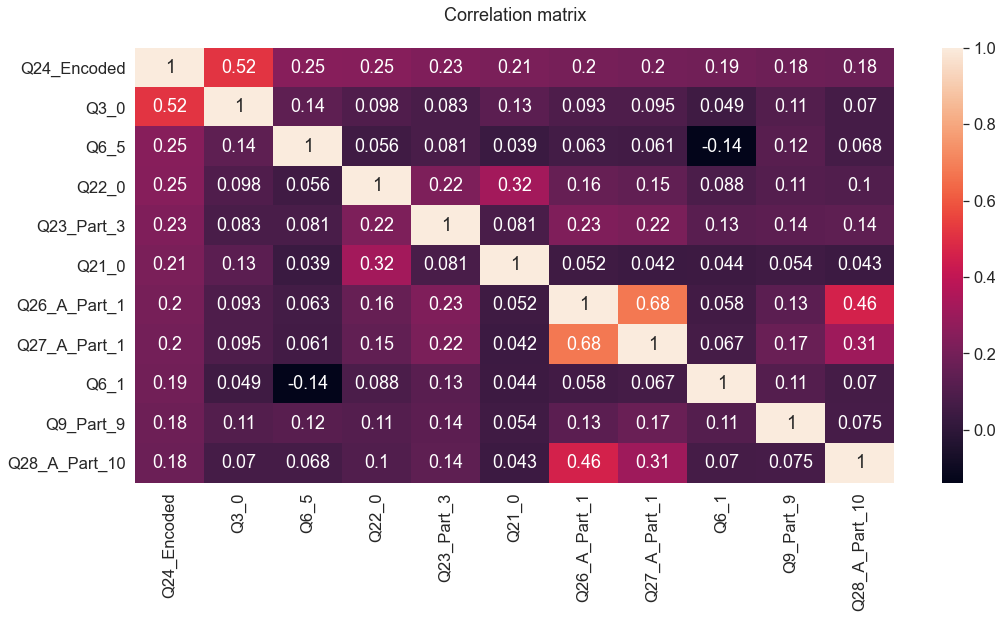

In [358]:
# visualize using heatmap
import seaborn as sns

hm = sns.heatmap(df_temp.corr(), annot = True)
hm.set(title = "Correlation matrix\n")
sns.set(rc = {'figure.figsize':(17,8)})
plt.show()

In [359]:
# Feature engineering is the process of transforming raw data into features that 
# better represent the underlying problem to the models.
# Sometimes it create new artificial features that aren’t in the training set
# The intension is to improved model accuracy on unseen data.
# In other words, the performance of the model is depending on data preprocessing and data handling.
# Apply feature engineering is very important in our task here. 
# Actually one-hot encoding we just applied is a technique of feature engineering.
# Techniques like scaling, ouliers handing and imputations are also included in feature engineering
# We have 450 features and some of them are highly correlated features. 
# We may need to remove one for each pair of highly correlated features.
# The data has high dimensions and we need to apply dimensionality reduction techniques.
# Otherwise we may have the 'curse of dimensionality' issue.
# We may want to extract the features that are most related to the target for better prediction accuracy.
# We also have imbalanced dataset here which we may apply some techniques to make our data more balanced.
# Otherwise the model may not learn to classify properly.
# because not all features are important for predicting the target.
# we will apply 2 feature engineering techniques below to do dimensionality reduction.


In [360]:
labels = df_data['Q24_Encoded'] # split targets and data
df_data.drop(['Q24_Encoded'],axis = 1,inplace = True)

In [361]:
df_data

,Q1_0,Q1_1,Q1_2,Q1_3,Q1_4,Q1_5,Q1_6,Q1_7,Q1_8,Q1_9,...,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
10726,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10727,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10728,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [362]:
for i in range(0,16):# we can see that we have very unbalanced dataset.    
    print(sum(labels == i))

4441
1114
714
540
552
510
408
394
273
280
573
315
347
115
153
0


In [363]:
# This is the solution I applied to solve the problem of imbalanced data.
# The technique is called oversampling using SMOTE
# but after applying this technique, I got over 60000 samples which is hard to run on my computer.
# So for this assignment I will just use the original dataset.
# SMOTE also support undersampling. But I do not think it's a good idea to apply it here since
# data from the majority class(label 0) are deleted which may be useful or even critical to make the classification decision.
"""
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# split into input and output elements
X, y = df_data.values,labels.values
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# transform the dataset
strategy = {0:4441, 1:4441, 2:4441, 3:4441, 4:4441, 5:4441, 6:4441, 
            7:4441, 8:4441, 9:4441, 10:4441, 11:4441, 12:4441, 13:4441, 14:4441}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
"""

"\n#!pip install imblearn\nfrom imblearn.over_sampling import SMOTE\nfrom collections import Counter\nfrom matplotlib import pyplot\nfrom sklearn.preprocessing import LabelEncoder\n\n# split into input and output elements\nX, y = df_data.values,labels.values\n# label encode the target variable\ny = LabelEncoder().fit_transform(y)\n# transform the dataset\nstrategy = {0:4441, 1:4441, 2:4441, 3:4441, 4:4441, 5:4441, 6:4441, \n            7:4441, 8:4441, 9:4441, 10:4441, 11:4441, 12:4441, 13:4441, 14:4441}\noversample = SMOTE(sampling_strategy=strategy)\nX, y = oversample.fit_resample(X, y)\n# summarize distribution\ncounter = Counter(y)\nfor k,v in counter.items():\n\tper = v / len(y) * 100\n\tprint('Class=%d, n=%d (%.3f%%)' % (k, v, per))\npyplot.bar(counter.keys(), counter.values())\npyplot.show()\n"

In [364]:
#df_data = pd.DataFrame(X) # for oversampling use only
#labels = pd.Series(y)

In [365]:
# First, we will use ExtraTreesClassifier to get the Feature Importance of our dataset
# ExtraTreesClassifier(Extremely Randomized Trees) is a method based on decision trees.
# It resembles random forest and randomizes certain decisions and subsets of data to prevent over-learning from data and overfitting.
# We can directly do feature selection based on its feature_importances_ method and choose the amount of features we want to keep.
# simply dropping columns based on feature_importances_ of ExtraTreesClassifieron is not good enough.
# we want to do a pca to further reduce dimension but preserve the variance of data.
# Another reason is that we want our pca to ignore those features classified as 'less important' and focus only on those most relevant features.
# So we first filter those 'less relevant features' out to let pca capture the real essense of the data.

In [366]:
model = ExtraTreesClassifier()
model.fit(df_data.values, labels.values.ravel())
# display the relative importance of each feature
print(model.feature_importances_)

[4.95273431e-03 4.43918201e-03 9.73986517e-03 2.01463952e-03
 2.73998040e-03 5.15664946e-03 4.01515894e-03 4.67586142e-03
 1.64652847e-03 3.53072209e-03 2.31623556e-04 3.90484698e-03
 3.51659689e-03 8.17176875e-05 6.96377822e-04 1.01780811e-04
 2.03503790e-02 4.16059029e-04 2.63646360e-03 2.41448673e-03
 6.39012226e-04 8.66741960e-03 1.68398808e-03 6.12369332e-04
 1.37334797e-03 4.55944481e-04 2.57048166e-03 5.00195288e-04
 1.29613617e-04 5.69951914e-04 2.97677326e-04 7.46146111e-04
 8.01408535e-04 1.52914896e-03 4.49990435e-04 4.86676241e-04
 2.64404686e-04 4.17510559e-03 2.09630114e-04 1.92010547e-03
 7.29039290e-04 8.16830187e-04 2.04864581e-03 1.72041167e-03
 2.92423059e-04 7.69009790e-04 2.22314103e-03 3.48234683e-04
 2.18824650e-03 1.15932782e-04 2.55037457e-04 4.65397428e-04
 4.25643693e-04 3.80244608e-04 5.29313763e-04 4.73610315e-04
 1.46203016e-03 4.75120319e-04 2.07566282e-04 3.85893462e-05
 1.85375946e-04 7.08918979e-04 2.00674482e-04 9.82622584e-04
 3.60061158e-04 2.331770

In [367]:
len(model.feature_importances_)

450

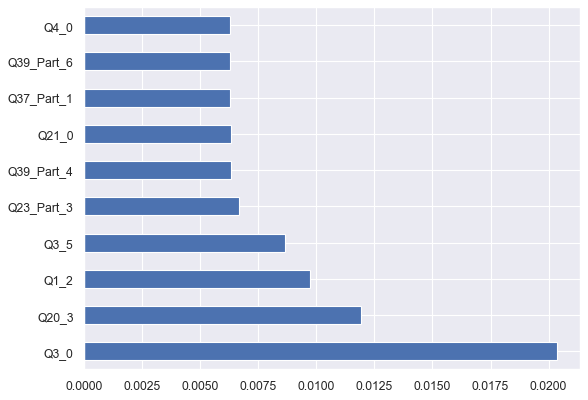

In [368]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
fi = pd.Series(model.feature_importances_, index = df_data.columns)# top 10 important features 
fi.nlargest(10).plot(kind='barh')
plt.show()

In [369]:
# we have nearly 450 features, first I apply the extra trees classifier to get the top 30% important features(importance > 0.0025)

In [370]:
importance = model.feature_importances_
features = []
for i,v in enumerate(importance):
    if v > 0.0025:
        features.append(i)# get the index of features that have importance over 0.0025
        

In [371]:
#features

In [372]:
len(features)/df_data.shape[1]#we filtered out 2/3 of the features, which is deemed less important by the alg.

0.3488888888888889

In [373]:
df_revised = df_data.iloc[:,features]
df_revised# we have 1/3 features left

,Q1_0,Q1_1,Q1_2,Q1_4,Q1_5,Q1_6,Q1_7,Q1_9,Q2_0,Q2_1,...,Q39_Part_7,Q39_Part_8,Q39_Part_9,Q39_Part_10,Q26_B_Part_1,Q26_B_Part_3,Q29_B_Part_1,Q31_B_Part_14,Q33_B_Part_7,Q35_B_Part_10
1,1,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,1,0,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,0,0
10726,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
10727,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
10728,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [374]:
# next, we want to apply pca for further dimensionality reduction
# principle component analysis is a tool to 'summarize' the existing data and features.
# In other words, it find a more meaningful basis or coordinate system for our data and find the strongest features 
# of the samples based on some covariance matrix.
# The goal is to extract the important information from the data and to express the information as 
# a set of summary features called principal components.
# The principle components are just like our features but they do not have names.
# The explained variance shows how much variance a principle component preserves.
# Usually, the first few principle components have majority of the explained variance. 
# it is a good technique to reduce data dimension and tackle the curse of dimensionality. 

In [375]:
pca = PCA(n_components=0.8)# we want our principle components to have 80% of the total explained variance 
pca.fit(df_revised)# use the resulting data from the previous step
pca.transform(df_revised)
eigenVectors = pca.components_  
eigenValues = pca.explained_variance_ 

In [376]:
#eigenVectors

In [377]:
len(eigenValues) # number of principle components we want to keep 

79

In [378]:
principal_component_projections = pca.transform(df_revised)
#pc1_proj = principal_component_projections[:,0]

In [379]:
pca.explained_variance_ratio_#large proprtion of variance is explained in the first few principle components

array([0.08922727, 0.04383547, 0.03474721, 0.02791603, 0.02282534,
       0.02007993, 0.01944606, 0.01749962, 0.01631066, 0.01552785,
       0.01420565, 0.01358039, 0.01284013, 0.01228643, 0.0120138 ,
       0.01141751, 0.01088099, 0.01059991, 0.01037539, 0.01003944,
       0.00985646, 0.00935726, 0.00897482, 0.00887373, 0.00872499,
       0.00847527, 0.00834744, 0.00827553, 0.00814593, 0.00809939,
       0.00799025, 0.00784878, 0.0077299 , 0.00767801, 0.00752954,
       0.00732284, 0.00722592, 0.00709711, 0.00698237, 0.00690317,
       0.00679038, 0.00673218, 0.00663741, 0.00653267, 0.00649523,
       0.00636534, 0.00630024, 0.00627102, 0.00625001, 0.00619225,
       0.00615389, 0.00609375, 0.00593744, 0.00588306, 0.00580856,
       0.00575788, 0.00568576, 0.00560038, 0.00552322, 0.00544385,
       0.00540627, 0.00536015, 0.00518938, 0.00516644, 0.00511018,
       0.0050789 , 0.00499171, 0.00497736, 0.00489606, 0.00487855,
       0.00481338, 0.00476216, 0.00472613, 0.00465334, 0.00462

In [380]:
# we further reduce our data dimensions by around 50% by using the first few principle components, which explained
# 80% of the total variance.

In [381]:
#sum_variance = 0
#for i in range(0,70):
#    sum_variance += eigenValues[i]
#sum_variance/np.sum(eigenValues)

In [382]:
principle_components = pd.DataFrame(principal_component_projections)
principle_components

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,1.961218,0.849828,-0.302103,-0.015213,0.995766,0.435241,0.384263,-0.504191,-1.228120,-0.696215,...,0.022406,0.727046,0.107604,-0.176344,0.221359,0.422321,-0.625893,0.133132,0.169067,0.214221
1,-2.126371,0.414505,-0.958241,-1.069345,0.845148,1.409136,1.702095,0.791589,0.049507,0.464012,...,0.068110,-0.106354,-0.088654,-0.037125,-0.092428,-0.599200,0.183238,-0.023893,0.313283,-0.563815
2,1.051151,1.747352,0.489841,0.503956,-1.239412,-0.634714,0.567860,0.576432,0.462273,-0.670556,...,-0.017745,-0.568599,-0.153195,-0.323931,0.010042,-0.132165,0.572580,0.043406,0.096322,-0.294081
3,2.514605,-0.047861,-1.404043,0.453814,-0.616812,0.100853,1.380033,-0.614943,-0.179586,0.200348,...,-0.325776,-0.256617,-0.716242,0.155690,0.097111,-0.503532,-0.812338,-0.049757,0.133960,-0.216136
4,-1.880649,1.322890,-0.727780,0.992212,-0.461184,1.284053,-1.463297,-0.126705,0.764118,0.692428,...,-0.107389,0.324731,0.041728,0.023327,-0.260893,-0.206952,-0.109627,-0.309026,0.325527,-0.546105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10724,0.868151,-1.884203,-0.490735,1.295685,0.107016,0.428461,0.318182,-0.084346,0.609818,0.223325,...,0.064034,0.453806,0.092623,-0.045078,0.382768,-0.493296,-0.190745,0.662622,0.148033,-0.121116
10725,-2.127672,1.098292,-0.589781,-0.012752,0.969261,-0.820072,0.748662,0.495498,-0.220014,0.475864,...,-0.145912,0.308594,-0.303468,0.423111,0.295881,-0.457690,0.096267,-0.152028,-0.279857,0.161310
10726,-1.609338,-0.810514,0.061528,-0.123791,-0.638224,-0.764890,-0.636208,-0.222497,0.694030,-0.813560,...,-0.130237,0.259476,0.044805,-0.202374,-0.156695,0.059552,0.156045,-0.353965,-0.321254,-0.104884
10727,2.447776,-1.427662,0.418549,0.289501,0.103843,-0.179591,0.613300,0.918770,-1.138679,0.843887,...,0.035526,0.196884,0.090783,0.023329,0.425354,-0.406791,0.297590,0.595687,-0.354508,-0.614494


In [383]:
principle_components.corr()#correlations of principle components are very small.

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,1.000000e+00,-7.743736e-16,1.283052e-16,2.186469e-16,2.107552e-16,1.975509e-16,2.379024e-16,-5.446867e-17,-5.938706e-17,-4.844534e-16,...,-9.494005e-17,3.153571e-16,1.753047e-17,2.503067e-17,-4.650924e-16,8.811669e-17,1.416858e-18,-3.079667e-16,8.054604e-17,1.598276e-16
1,-7.743736e-16,1.000000e+00,-5.960144e-16,3.153449e-19,6.753727e-16,2.065125e-16,6.604587e-17,1.242423e-16,-8.595861e-17,-3.537107e-16,...,1.847287e-17,1.754757e-16,8.529910e-18,-1.733113e-17,3.038665e-17,4.334005e-17,-8.533613e-17,6.977194e-18,6.047677e-17,-5.289868e-17
2,1.283052e-16,-5.960144e-16,1.000000e+00,4.116395e-16,-1.354960e-16,-1.139767e-16,2.137664e-16,1.465982e-16,-1.244656e-16,9.186457e-17,...,-1.914526e-16,3.440522e-16,1.171583e-16,5.768571e-17,-3.898292e-16,2.436556e-17,-5.138239e-17,-1.434197e-16,1.887891e-16,1.886571e-16
3,2.186469e-16,3.153449e-19,4.116395e-16,1.000000e+00,-1.186084e-15,1.254348e-16,8.762095e-16,9.781291e-17,-7.949562e-17,5.943612e-16,...,-5.011197e-17,1.058328e-16,-1.489429e-17,-4.135677e-18,-3.649420e-17,-3.194280e-17,9.278608e-18,-9.948432e-18,-2.918948e-17,2.803028e-18
4,2.107552e-16,6.753727e-16,-1.354960e-16,-1.186084e-15,1.000000e+00,2.789094e-16,1.013724e-15,-1.187484e-16,1.633314e-16,-1.980601e-16,...,2.791485e-17,1.032166e-16,1.060710e-17,-3.523194e-17,-1.084358e-16,-1.517480e-16,1.383433e-17,-9.064894e-17,-3.863695e-16,-1.456843e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,8.811669e-17,4.334005e-17,2.436556e-17,-3.194280e-17,-1.517480e-16,-2.199010e-16,-1.939308e-16,-9.781714e-17,-3.842547e-17,-1.550104e-16,...,2.293183e-16,7.180906e-16,3.897423e-16,-7.962020e-16,1.091198e-16,1.000000e+00,-2.333280e-15,4.507140e-16,-7.196804e-16,4.505957e-17
75,1.416858e-18,-8.533613e-17,-5.138239e-17,9.278608e-18,1.383433e-17,-9.373693e-18,1.413611e-16,-2.477767e-16,5.034578e-17,3.289287e-16,...,-3.356674e-16,-5.631032e-18,3.961685e-16,-6.483804e-16,3.829485e-16,-2.333280e-15,1.000000e+00,-6.493167e-16,-4.064975e-17,2.053254e-16
76,-3.079667e-16,6.977194e-18,-1.434197e-16,-9.948432e-18,-9.064894e-17,3.479833e-17,-2.370803e-16,-1.193941e-16,9.588794e-17,-8.132341e-16,...,-3.634765e-17,-5.437941e-16,-4.897757e-17,-4.389061e-16,-2.526007e-16,4.507140e-16,-6.493167e-16,1.000000e+00,6.287271e-17,-3.408293e-16
77,8.054604e-17,6.047677e-17,1.887891e-16,-2.918948e-17,-3.863695e-16,-3.223848e-16,-5.451518e-17,9.272415e-17,-2.529022e-16,-6.432067e-16,...,-1.119947e-17,1.673435e-16,-6.742870e-16,4.390503e-16,-3.529160e-16,-7.196804e-16,-4.064975e-17,6.287271e-17,1.000000e+00,1.714439e-16


In [384]:
df_revised = principle_components.iloc[:,0:]

In [385]:
df_revised# this is the data we will use in the next parts

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,1.961218,0.849828,-0.302103,-0.015213,0.995766,0.435241,0.384263,-0.504191,-1.228120,-0.696215,...,0.022406,0.727046,0.107604,-0.176344,0.221359,0.422321,-0.625893,0.133132,0.169067,0.214221
1,-2.126371,0.414505,-0.958241,-1.069345,0.845148,1.409136,1.702095,0.791589,0.049507,0.464012,...,0.068110,-0.106354,-0.088654,-0.037125,-0.092428,-0.599200,0.183238,-0.023893,0.313283,-0.563815
2,1.051151,1.747352,0.489841,0.503956,-1.239412,-0.634714,0.567860,0.576432,0.462273,-0.670556,...,-0.017745,-0.568599,-0.153195,-0.323931,0.010042,-0.132165,0.572580,0.043406,0.096322,-0.294081
3,2.514605,-0.047861,-1.404043,0.453814,-0.616812,0.100853,1.380033,-0.614943,-0.179586,0.200348,...,-0.325776,-0.256617,-0.716242,0.155690,0.097111,-0.503532,-0.812338,-0.049757,0.133960,-0.216136
4,-1.880649,1.322890,-0.727780,0.992212,-0.461184,1.284053,-1.463297,-0.126705,0.764118,0.692428,...,-0.107389,0.324731,0.041728,0.023327,-0.260893,-0.206952,-0.109627,-0.309026,0.325527,-0.546105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10724,0.868151,-1.884203,-0.490735,1.295685,0.107016,0.428461,0.318182,-0.084346,0.609818,0.223325,...,0.064034,0.453806,0.092623,-0.045078,0.382768,-0.493296,-0.190745,0.662622,0.148033,-0.121116
10725,-2.127672,1.098292,-0.589781,-0.012752,0.969261,-0.820072,0.748662,0.495498,-0.220014,0.475864,...,-0.145912,0.308594,-0.303468,0.423111,0.295881,-0.457690,0.096267,-0.152028,-0.279857,0.161310
10726,-1.609338,-0.810514,0.061528,-0.123791,-0.638224,-0.764890,-0.636208,-0.222497,0.694030,-0.813560,...,-0.130237,0.259476,0.044805,-0.202374,-0.156695,0.059552,0.156045,-0.353965,-0.321254,-0.104884
10727,2.447776,-1.427662,0.418549,0.289501,0.103843,-0.179591,0.613300,0.918770,-1.138679,0.843887,...,0.035526,0.196884,0.090783,0.023329,0.425354,-0.406791,0.297590,0.595687,-0.354508,-0.614494


In [386]:
# PART 3 Model implementation

In [387]:
# we should apply normalization/standardization before applying pca but we may or may not apply scaling to the resulting data of pca. 
# After applying pca the data are more or less of the same scale(not exactly on the same scale) 
# and we normally scale data if the range values for features are different.
# But we can also scale the data to keep them in a range of (0,1) so that our model does not bias towards larger values.
# PCA calculates a new projection of the data set. In other words, we get new features. 
# And the new axis are based on the standard deviation of the variables. 
# So a variable with a high standard deviation will have a higher weight for the calculation of axis. 
# Normalizing the data before applying pca makes all variables have the same standard deviation, and all variables have the same weight.
# But since we only hava binary data (onehot encoding), It is not necessary to do the scaling as well. They are already in scope(0,1). 

In [388]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_revised,labels,test_size = 0.3,random_state=15)
print("train_shape={},test_shape={}".format(X_train.shape,X_test.shape))

train_shape=(7510, 79),test_shape=(3219, 79)


In [389]:
# this is the alg that makes our targets for prediction
# the number we input, eg 3, tells the alg to take any target values <= 3 as group 0
# and any value > 3 as group 1.
def to_binary(zero_class_largest_label):
    series = pd.Series(np.where(y_train.values <= zero_class_largest_label, 0, 1),
          X_train.index)
    return series

In [390]:
df_binary = pd.DataFrame()

In [391]:
for i in range(0,14):# repeat for 15 - 1 labels because probability of belonging to target 15 can be get directly later.
    df_binary['train_target{}'.format(i)] = to_binary(i)

In [392]:
#df_binary['train_target13'].unique()

In [393]:
df_binary# put them in a df

,train_target0,train_target1,train_target2,train_target3,train_target4,train_target5,train_target6,train_target7,train_target8,train_target9,train_target10,train_target11,train_target12,train_target13
915,1,1,1,1,1,1,1,1,1,0,0,0,0,0
4122,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10430,1,1,1,1,1,1,1,0,0,0,0,0,0,0
1318,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5335,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528,1,1,1,1,1,1,1,0,0,0,0,0,0,0
2693,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8076,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3829,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [394]:
#X_train, X_test, y_train, y_test = train_test_split(df_revised,labels,test_size = 0.3,random_state=15)
#print("train_shape={},test_shape={}".format(X_train.shape,X_test.shape))

In [395]:
#we keep a array that record the probability belongs to each class for each sample in validation set
probabilities =  np.empty((751, 15)) 

In [396]:
df_x = pd.DataFrame(X_train)
df_y = pd.DataFrame(y_train)

In [397]:
# The alg to do ordinal multiclass logistic regression.

In [398]:
kfold = KFold(n_splits=10)# 10 fold cv
kfold.get_n_splits(np.array(df_x))
accuracy = np.zeros(10)# record accuracy for each fold
predictions = []

In [399]:
def hyperparameter_test(solver='liblinear',penalty='l2',C = 0.01,df_x =df_x ,df_y=df_y):
    np_idx = 0
    scaler = StandardScaler()

    model = LogisticRegression(solver = solver,penalty = penalty, C=C)# hyperparameters can be passed manually
    for train_idx, val_idx in kfold.split(np.array(df_x)):# train and validation index
        #print(train_idx, val_idx)
        X_train, X_val = df_x.values[train_idx], df_x.values[val_idx]
        y_train, y_val = df_y.values[train_idx], df_y.values[val_idx]
        X_train = scaler.fit_transform(X_train) # scaling
        X_val = scaler.transform(X_val)
        for i in range(0,14):# we need to do 14 predictions in order to get the probabilities belonging to the 15 labels
            model.fit(X_train,df_binary['train_target{}'.format(i)].values[train_idx])# each time fit the model using different targets we prepared above 
            predictions = model.predict_proba(X_val) # predict based on the different targets and the same training data each turn 
            #print(predictions[:,0][0])
            if i == 0 :# if only take label 0 as group 0, we get the probability belonging to label 0 directly.
                probabilities[:,i] =  predictions[:,0] # prediction[0] is the probability belonging to group 0 and prediction[1] for group 1
            elif i in range(1,14) : # when we take multiple labels as group 0
                sum_prob = 0 # we need to compute the total probabilities belonging to the previous labels
                for j in range(0,i):
                    sum_prob += probabilities[:,j] # get the sum of all previous probabilities
                probabilities[:,i] = predictions[:,0] - sum_prob # we use the (probabilities of group 0) - (the sum of probabilities from previous labels(label 0 - label i-1))
            if i ==13 : # if taking label 0 to label 13 as group 0, we compute probability for label 14 directly.  
                probabilities[:,i+1] = predictions[:,1] # group 1 only contain the probability of label 14

        predictions = np.array(pd.DataFrame(probabilities).idxmax(axis="columns")).reshape(-1,1)#pick the index of the largest probability for each instance

        #print(predictions)

        #print(confusion_matrix(y_val, predictions)) 

        ACC = accuracy_score(y_val, predictions)# use accuracy as a temporary performance metric here

        accuracy[np_idx] = ACC*100
        np_idx += 1

        #print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))  
        #break

    print ("C = {}, penalty = {}, solver = {} Average Score: {}%({})".format(C, penalty , solver ,
        round(np.mean(accuracy),3),round(np.var(accuracy),3)))


In [400]:
#np.array(pd.DataFrame(probabilities).idxmax(axis="columns"))

In [401]:
#np.unique(predictions)

In [402]:
# we treat each of the hyperparameter(s) as a new model and compare the result

In [403]:
for solver in ['liblinear','saga']: # only these 2 solvers support l1 penalty
    for C in [0.0001, 0.001,0.005,0.01,0.05,0.1,1,10]:
        for penalty in ['l1','l2']:
            hyperparameter_test(solver = solver,penalty = penalty, C=C)

C = 0.0001, penalty = l1, solver = liblinear Average Score: 41.571%(3.889)
C = 0.0001, penalty = l2, solver = liblinear Average Score: 41.891%(3.143)
C = 0.001, penalty = l1, solver = liblinear Average Score: 41.571%(3.889)
C = 0.001, penalty = l2, solver = liblinear Average Score: 41.904%(3.043)
C = 0.005, penalty = l1, solver = liblinear Average Score: 41.931%(3.746)
C = 0.005, penalty = l2, solver = liblinear Average Score: 43.609%(2.983)
C = 0.01, penalty = l1, solver = liblinear Average Score: 42.65%(2.656)
C = 0.01, penalty = l2, solver = liblinear Average Score: 43.569%(2.716)
C = 0.05, penalty = l1, solver = liblinear Average Score: 43.502%(3.234)
C = 0.05, penalty = l2, solver = liblinear Average Score: 43.316%(2.982)
C = 0.1, penalty = l1, solver = liblinear Average Score: 43.449%(3.646)
C = 0.1, penalty = l2, solver = liblinear Average Score: 43.316%(2.702)
C = 1, penalty = l1, solver = liblinear Average Score: 43.262%(2.285)
C = 1, penalty = l2, solver = liblinear Average S

In [404]:
#The accuracy across folds does not vary too much. average accuracies and their variances are shown above.

In [405]:
# Our best model here has C = 0.005, penalty = l2, solver = saga
# For logistic regression, the smaller the c, the stronger the regularization. l1(Lasso) has more regularization power than l2(Ridge)
# regularization is a way to prevent overfitting and to tackle high variance
# and We want to penalize or adjust each weight of the independent variables so that 
# it makes a good prediction on a test set that it has not seen before.
# we want to choose a middle point of having high bias and high variance.
# C is 1/λ, If we decrease c, we are essentially decrease the model complexity.
# So the variance decreases and bias increases.
# The more complex the model, the lower its bias and complexity will move the model to capture the data points, and hence its variance will be larger.
# But if variance is high, the model is not going to do well on the testing data because the model is more "spread out".
# From the result we can see that our best model has the best validation score which means it generalizes what it learns well 
# and it acheives a good balance between bias and variance. In other words a good balance between model complexity and generalization.
# We also need to be careful not to penalize the model too much, otherwise our model will be underfitted.
# which means the model may not perform well on both the training and test set.


In [406]:
pd.DataFrame(probabilities)# a probability table is kept(refresh after each cv), we do not keep a table for each cv.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.713991,0.109335,0.052556,0.025965,0.026950,0.028934,0.016569,0.010077,0.005644,0.000245,0.002834,-0.005563,0.010496,0.000176,0.001792
1,0.467637,0.180113,0.123749,0.041541,0.058249,0.072210,0.017873,0.015918,0.003303,0.005085,0.008367,0.004268,0.001395,0.000187,0.000105
2,0.831628,0.067807,0.014481,0.022916,0.024117,0.011210,0.007379,0.001076,0.003715,0.004192,0.006472,0.002600,0.001450,0.000329,0.000629
3,0.754474,0.144644,0.045644,0.013039,0.007162,0.016655,0.003575,0.000039,0.000830,0.004144,0.004426,0.000982,-0.001654,0.001254,0.004786
4,0.052537,-0.001141,0.003998,0.006656,0.014925,0.062839,-0.020206,-0.008193,0.025609,0.037410,0.154455,0.151073,0.270317,0.090354,0.159367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.139619,0.122900,0.065176,0.042355,0.027156,0.060923,0.175508,0.139863,-0.002294,0.074913,0.106915,0.019619,-0.009001,-0.011308,0.047656
747,0.655646,0.244738,0.028304,0.024608,0.024085,0.010866,0.006070,0.002405,0.001232,0.000652,0.001203,0.000047,0.000081,-0.000043,0.000106
748,0.816667,0.109287,0.019439,0.020652,0.012969,0.009332,0.002653,0.001067,0.002677,0.001253,0.002790,0.000458,-0.001151,0.000955,0.000951
749,0.217958,0.018776,0.005666,0.052839,0.081147,0.013751,0.017780,0.082127,-0.038288,0.045832,0.145335,0.207636,0.120468,-0.036428,0.065400


In [407]:
#C = 0.005, penalty = l2, solver = saga Average Score: 43.475%(2.696)

In [408]:
#PART 4

In [409]:
# Penalty, C and solver are the hyperparameters I use. 
# I would choose penalty and C because strictly speaking, solver is not a hyperparameter.
# (also mentioned in lecture). But I include the solver option here just to see the output.
# I only use liblinear and saga solver here because only these 2 support both l1 and l2 regularization.
# C and penalty are the regularization terms for logistic regression.
# Determining their values are critical for getting a good prediction model for the test set.
# Small C indicates strong regularization and l1 has stronger regularization power than l2.
# we need to carefully choose their values to seek a balance between bias and variance.
# The purpose of regularization is to prevent overfitting so that we also get reasonable result on the test set.
# But we also need to be careful that when regularization is too strong,
# the model tends to underfit. Which has high bias and high variance.
# If the penalty is too weak, the model will be allowed to overfit the training data. Which has low bias and high variance.

In [410]:
#Then we build a model with hyperparameter tuning

In [ ]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

In [411]:
def hyperparameter_tuning(penalties,Cs ,solvers ,df_x =df_x ,df_y=df_y):
    model = LogisticRegression()
    scaler = StandardScaler()
    
    best_model = model
    best_params = {}
    best_accuracy = 0
    #best_std = 0
    best_var = 0
    np_idx = 0
    
    for C in Cs:
        for penalty in penalties:  
            for solver in solvers:
                model = LogisticRegression(penalty = penalty, C=C,solver = solver)
                accuracy = np.zeros(10)
                np_idx = 0
                for train_idx, val_idx in kfold.split(np.array(df_x)):
                    #print(train_idx, val_idx)
                    X_train, X_val = df_x.values[train_idx], df_x.values[val_idx]
                    y_train, y_val = df_y.values[train_idx], df_y.values[val_idx]
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)

                    for i in range(0,14):# algorithm to compute the probability belong to each target value 
                        model.fit(X_train,df_binary['train_target{}'.format(i)].values[train_idx])
                        predictions = model.predict_proba(X_val) 
                        #print(predictions[:,0][0])
                        if i == 0 :
                            probabilities[:,i] =  predictions[:,0]
                        elif i in range(1,14) :
                            sum_prob = 0
                            for j in range(0,i):
                                sum_prob += probabilities[:,j]
                            probabilities[:,i] = predictions[:,0] - sum_prob  #[probabilities[:,j] for j in range(0,i)]
                        if i ==13 :
                            probabilities[:,i+1] = predictions[:,1]

                    predictions = np.array(pd.DataFrame(probabilities).idxmax(axis = 1)).reshape(-1,1)#pick the index of the largest probability

                    #print(predictions)

                    #print(confusion_matrix(y_val, predictions)) 

                    #ACC = accuracy_score(y_val, predictions)
                    f1 = f1_score(y_val, predictions,average='weighted')
                    accuracy[np_idx] = f1*100
                    np_idx += 1

                print ("Average F1 score: {}%({})".format(round(np.mean(accuracy),3),round(np.var(accuracy),3)))
                if np.mean(accuracy) > best_accuracy:
                    best_model = model
                    best_params = {'C':C, 'penalty':penalty, 'solver':solver}
                    best_accuracy = np.mean(accuracy)
                    best_var = np.var(accuracy)

    print (best_params)
    print ("Best F1 Score: {}%({})".format(round(best_accuracy,3),round(best_var,3)))      

    print ("\nThe optimal model uses C={}, a {} solver, and a {} penalty, and has a cross validation score of {}% with a variance of {}".format(best_params['C'],best_params['solver'],best_params['penalty'],round(best_accuracy,3),round(best_var,3)))
    return best_model
    

In [412]:
best_model = hyperparameter_tuning(penalties = ['l1', 'l2'], Cs=[0.001,0.01,0.05,0.1,0.5,1,10,100,1000],solvers= ['liblinear','saga'] )

Average F1 score: 24.442%(3.872)
Average F1 score: 24.442%(3.872)
Average F1 score: 26.106%(3.706)
Average F1 score: 25.769%(3.707)
Average F1 score: 27.564%(2.759)
Average F1 score: 27.925%(2.833)
Average F1 score: 30.958%(4.094)
Average F1 score: 31.52%(4.931)
Average F1 score: 31.701%(4.717)
Average F1 score: 31.949%(5.132)
Average F1 score: 32.519%(4.592)
Average F1 score: 32.661%(4.275)
Average F1 score: 32.47%(5.733)
Average F1 score: 32.548%(5.635)
Average F1 score: 32.802%(4.234)
Average F1 score: 32.85%(3.681)
Average F1 score: 32.867%(3.798)
Average F1 score: 32.876%(3.784)
Average F1 score: 32.874%(3.56)
Average F1 score: 32.925%(3.277)
Average F1 score: 32.993%(3.561)
Average F1 score: 32.97%(3.559)
Average F1 score: 32.984%(3.456)
Average F1 score: 32.954%(3.485)
Average F1 score: 32.986%(3.486)
Average F1 score: 32.979%(3.478)
Average F1 score: 32.97%(3.534)
Average F1 score: 32.962%(3.517)
Average F1 score: 32.967%(3.507)
Average F1 score: 32.967%(3.507)
Average F1 score

In [413]:
#I use F1 score here because of the following reasons.
#Our dataset is imbalanced, for example, we have target 0 much more than other targets(also shown below).
#This may create problems because the model is more likely to give an answer of class 0 on the test set.
#And most of the cases, it will get right answer because our test data is imbalanced too.
#Accuracy rate only calculates the number of right answers/the number of total answers
#So we need to introduce metrics that give more weights to the false positive and false negative rate.
#In many cases, our model may give good predictions for actual class 0, but bad predictions for other classes 
# because the models learns more about class 0(imbalanced dataset).
#Precision, Recall and F1 score are crucial indicators to judge a imbalanced dataset.
#F1 score is a comprehensive metric which take into account the precision and recall.
#f1 = 2*precision*recall/(precision+recall)
#precision = TP/(TP+FP) and recall = TP/(TP+FN)
#we can see that f1 take into account the FN and FP rate. In other words, it take into accounts how our data is actually distributed.
#And there maybe large amount of actual negatives in our dataset.
#So because FN and FP is important to evaluate our model here, we use f1 instead of accuracy.

In [414]:
for i in range(0,15):# we can see that we have very unbalanced dataset.    
    print(sum(labels == i))

4441
1114
714
540
552
510
408
394
273
280
573
315
347
115
153


In [415]:
df_binary

,train_target0,train_target1,train_target2,train_target3,train_target4,train_target5,train_target6,train_target7,train_target8,train_target9,train_target10,train_target11,train_target12,train_target13
915,1,1,1,1,1,1,1,1,1,0,0,0,0,0
4122,1,1,0,0,0,0,0,0,0,0,0,0,0,0
10430,1,1,1,1,1,1,1,0,0,0,0,0,0,0
1318,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5335,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6528,1,1,1,1,1,1,1,0,0,0,0,0,0,0
2693,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8076,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3829,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [416]:
pd.DataFrame(probabilities)# The output of predict_proba for the tenth cross validation of the last model

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.714010,0.109349,0.052560,0.025964,0.026952,0.028915,0.016569,0.010078,0.005638,0.000244,0.002833,-0.005554,0.010490,0.000173,0.001780
1,0.467617,0.180142,0.123793,0.041581,0.058122,0.072255,0.017885,0.015916,0.003302,0.005081,0.008361,0.004263,0.001392,0.000186,0.000104
2,0.831685,0.067790,0.014458,0.022941,0.024103,0.011211,0.007372,0.001073,0.003718,0.004182,0.006472,0.002596,0.001447,0.000327,0.000625
3,0.754499,0.144662,0.045634,0.013020,0.007168,0.016648,0.003583,0.000045,0.000826,0.004143,0.004429,0.000983,-0.001622,0.001237,0.004744
4,0.052504,-0.001149,0.004000,0.006648,0.014912,0.062816,-0.020205,-0.008209,0.025606,0.037393,0.154370,0.151067,0.270495,0.090298,0.159456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0.139560,0.122921,0.065134,0.042392,0.027108,0.060967,0.175530,0.139920,-0.002309,0.074935,0.106893,0.019636,-0.009004,-0.011394,0.047710
747,0.655614,0.244809,0.028312,0.024585,0.024086,0.010859,0.006063,0.002402,0.001229,0.000652,0.001201,0.000047,0.000081,-0.000042,0.000104
748,0.816717,0.109275,0.019427,0.020646,0.012961,0.009336,0.002646,0.001072,0.002671,0.001250,0.002788,0.000457,-0.001147,0.000953,0.000946
749,0.217922,0.018771,0.005659,0.052777,0.081157,0.013702,0.017713,0.082151,-0.038227,0.045827,0.145287,0.207762,0.120510,-0.036628,0.065616


In [417]:
pd.DataFrame(probabilities).sum(axis = 1)# every row the probability is added to 1

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
746    1.0
747    1.0
748    1.0
749    1.0
750    1.0
Length: 751, dtype: float64

In [418]:
# PART 5 Testing

In [419]:
predictions = []

In [420]:
probabilities =  np.empty((3219, 15))

In [421]:
# test set

#model = LogisticRegression(solver = 'liblinear',penalty = 'l2', C=10)
scaler = StandardScaler()
X_train=df_x.values
y_train=df_y.values
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
for i in range(0,14):# algorithm to compute the probability belong to each target value 
    best_model.fit(X_train,df_binary['train_target{}'.format(i)].values)# use the best model directly from previous session
    predictions = best_model.predict_proba(X_test) 
    #print(predictions[:,0][0])
    if i == 0 :
        probabilities[:,i] =  predictions[:,0]
    elif i in range(1,14) :
        sum_prob = 0
        for j in range(0,i):
            sum_prob += probabilities[:,j]
        probabilities[:,i] = predictions[:,0] - sum_prob  
    if i ==13 :
        probabilities[:,i+1] = predictions[:,1]
#pick the index of the largest probability as the algorithm's answer(prediction)
predictions = np.array(pd.DataFrame(probabilities).idxmax(axis = 1)).reshape(-1,1)

#print(predictions)

#print(confusion_matrix(y_val, predictions)) 

ACC = accuracy_score(y_test, predictions)*100
f1 = f1_score(y_test, predictions,average='weighted')*100
#accuracy[np_idx] = ACC*100
#np_idx += 1

#print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))  
#break

print ("accuracy: {}%, f1: {}%".format(
round(np.mean(ACC),3), round(np.mean(f1),3)))


accuracy: 42.653%, f1: 32.472%


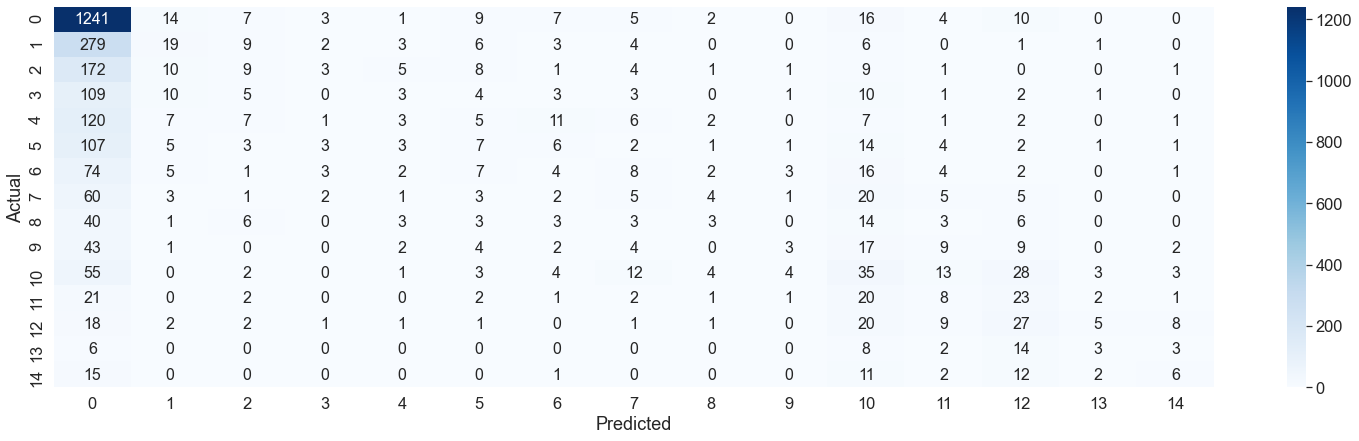

In [422]:
#we plot the confusion metrix of test set as follows
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (26,7))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap="Blues", fmt = 'g',annot=True,annot_kws={"size": 16})

In [423]:
#plt.scatter(np.array(y_test),predictions)

In [424]:
recall_score(y_test, predictions, average='weighted')

0.4265299782541162

In [425]:
precision_score(y_test, predictions, average='weighted')

0.3022999640536666

In [426]:
probabilities =  np.empty((7510, 15))

In [427]:
# train set

#model = LogisticRegression(solver = 'liblinear',penalty = 'l2', C=10)
X_train=df_x.values
y_train=df_y.values
X_train = scaler.fit_transform(X_train)
for i in range(0,14):# algorithm to compute the probability belong to each target value 
    best_model.fit(X_train,df_binary['train_target{}'.format(i)].values) # use best model directly from previous session  
    predictions = best_model.predict_proba(X_train) 
    #print(predictions[:,0][0])
    if i == 0 :
        probabilities[:,i] =  predictions[:,0]
    elif i in range(1,14) :
        sum_prob = 0
        for j in range(0,i):
            sum_prob += probabilities[:,j]
        probabilities[:,i] = predictions[:,0] - sum_prob  
    if i ==13 :
        probabilities[:,i+1] = predictions[:,1]
#pick the index of the largest probability as the algorithm's answer(prediction)
predictions = np.array(pd.DataFrame(probabilities).idxmax(axis = 1)).reshape(-1,1)

#print(predictions)

#print(confusion_matrix(y_val, predictions)) 

ACC = accuracy_score(y_train, predictions)*100
f1 = f1_score(y_train, predictions,average='weighted')*100
#accuracy[np_idx] = ACC*100
#np_idx += 1

#print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))  
#break

print ("accuracy: {}%, f1: {}%".format(
round(np.mean(ACC),3), round(np.mean(f1),3)))


accuracy: 45.766%, f1: 36.069%


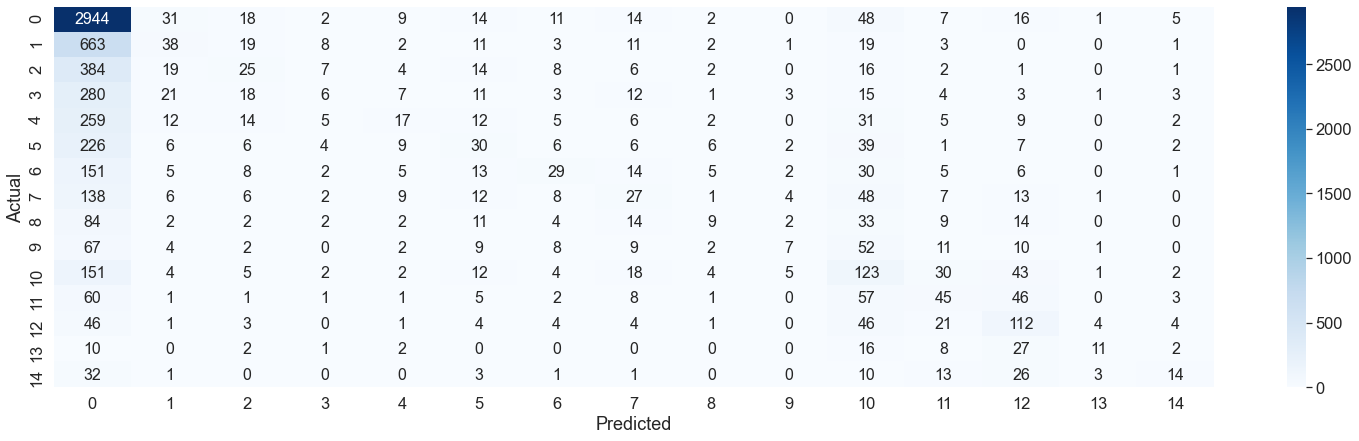

In [428]:
#we plot the confusion metrix of training set as follows
cm = confusion_matrix(y_train, predictions)
df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (26,7))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap="Blues", fmt = 'g',annot=True,annot_kws={"size": 16})

In [429]:
df_cm.sum(axis = 0).sum()

7510

In [430]:
#plt.scatter(np.array(y_train).reshape(1,-1),predictions.reshape(1,-1))

In [431]:
#np.unique(predictions)

In [432]:
#np.unique(y_train)

In [433]:
recall_score(y_train, predictions, average='weighted')

0.4576564580559254

In [434]:
precision_score(y_train, predictions, average='weighted')

0.36049718072352166

In [435]:
pd.DataFrame(probabilities)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.606866,0.140406,0.082910,0.071955,0.019447,0.023159,0.018226,-0.002397,-0.003812,-0.001581,0.016421,-0.009002,0.016310,-0.014670,0.035762
1,0.455780,0.058349,0.073698,0.123908,0.071892,0.090004,0.030322,0.023181,-0.007606,0.022211,0.008966,-0.004250,0.042280,-0.055337,0.066602
2,0.056665,0.035947,0.089143,0.049447,0.149077,0.149129,0.136287,0.004437,0.036144,0.064197,0.129340,0.056053,0.026228,0.011794,0.006111
3,0.259269,0.013648,0.037248,0.025604,0.080062,-0.005498,0.017328,0.037240,0.012845,0.065793,0.101069,0.217354,0.048780,0.059221,0.030036
4,0.783573,0.059515,0.053841,0.036793,0.018539,0.005889,0.012113,0.008963,0.004520,-0.000588,0.006148,-0.002856,0.008730,-0.002535,0.007356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7505,0.145833,0.119558,0.073223,0.031204,0.054170,0.051201,0.150877,0.178788,-0.007086,0.061411,0.091723,0.024893,-0.019770,0.005211,0.038763
7506,0.672483,0.235758,0.028739,0.021768,0.018694,0.009996,0.005736,0.002187,0.001902,0.000662,0.001729,0.000026,0.000178,-0.000069,0.000209
7507,0.810533,0.120071,0.019251,0.015846,0.013657,0.008330,0.002747,0.001485,0.002912,0.001179,0.002828,0.000476,-0.001188,0.000672,0.001201
7508,0.250850,0.019291,0.013268,0.063337,0.073956,0.014783,0.029910,0.089192,-0.031673,0.038819,0.103169,0.196236,0.111042,-0.020001,0.047820


In [436]:
# The accuracy and f1 score does not vary much when comparing the performance of test set and training set.
# To increase the accuracy, the following may be applied
# 1.use more principle components to do the prediction.In this assignment, I only use half of the principle components(about 80% of the explained variance).
# 2.using oversampling technique(using SMOTE mentioned above) to make our dataset more balanced will likely to increase accuracy
# SMOTE is an Over Sampling technique which is used to increase the data points for minority classes by augmenting data with similar data points as of the minority class.
# 3.Obviously, we can try more hyperparameters(more slovers and try penalty = elasticnet, etc)
# we can also try hyperparameters like 'class_weight', random_state to get a model with better accuracy.
# 4.We use the importance from ExtraTreeClassifier as our first tool and PCA as our second tool to reduce data dimension,
# which can be replaced by other techniques like LDA, It is similar to PCA.
# LDA finds the components that maximize both the variance of the data and the separation between multiple classes. 
# It is often used for classification models.
# We can also use SVD, Contrary to PCA, it does not center the data before computing the singular value decomposition. 
# Simply taking features that are highly correlated to the target can also be tried.

In [437]:
#Overfitting refers to the situation where the model performs well on training data but badly on the test data.
#Underfitting refers to the situation where the model performs badly on both training and test data.
#From the result we get, there is no overfitting and underfitting problem.
#The accuracy and f1 score for training set is around 3% higher than the test set, which is totally acceptable.
#And the accuracy of the test set is similar to the result we get from validation set in part 3 and 4.
#So it indicates that there are no severe issues of underfitting and overfitting and
#it seems that our model has found a good balance between variance and bias and the regularization we imposed is moderate.


In [438]:
#The insight I gained is as follows
# 1.Proportion of participants and their yearly compensation:
# 0-9,999 : 41.4%
# 10000-19999 : 10.4%
# 20000-29999 : 6.7% 
# 30000-39999 : 5.0%
# 40000-49999 : 5.1%
# 50000-59999 : 4.8%
# 60000-69999 : 3.8%
# 70000-79999 : 3.7%
# 80000-89999 : 2.5%
# 90000-99999 : 2.6%
# 100000-124999 : 5.3%
# 125000-149999 : 2.9%
# 150,000-199,999 : 3.2%
# 200,000-249,999 : 1.1%
# >250,000 : 1.4%

#We can see that half of the participants have a yearly compensation <= 19999. The distribution of higher compensation class is sparse

# 2. From the feature_importance_ of the ExtraTreeClassifier, we can see that whether the participant is from the US or not is highly 
# related to their yearly compensation.(almost have 2 times the importance of the second important feature)

# 3. the recall for our model is acceptable, but the precision is bad. Which means the model has more avg FP cases than avg FN cases.
# We cannot directly see this from the accuracy score, but we can use metrics like f1 score to show the combination of these 2 indicators.

In [439]:
#for i in range(0,15):# we can see that we have very unbalanced dataset.    
#    print(round(sum(labels == i)/10729,4)*100,'%')

In [440]:
#for train_idx, val_idx in kfold.split(np.array(df_x)):
    #print(train_idx)